Train models on different numbers of unlabeled sequences, infer embeddings, and then calculate test metrics. 

In [ ]:
import multiprocessing
import os
import pickle
import random

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy import stats
from sklearn import model_selection
from sklearn import metrics

from gpmodel import gpmodel
from gpmodel import gpkernel
from gpmodel import gptools
from embeddings_reproduction import embedding_tools

In [ ]:
%matplotlib inline

In [ ]:
sns.set_style('white')
sns.set_context('paper')

In [ ]:
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'axes.labelsize': 25})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'axes.titlesize': 25})

plt.rcParams.update({'axes.grid': False})

In [1]:
# assert gensim.__version__ == '1.0.1'
# assert np.__version__ == '1.13.1'
# assert pd.__version__ == '0.20.3'

In [2]:
sequence_dict = {}
sequence_dict['original'] = pd.read_csv('../inputs/uniprot-reviewed-lim_sequences.txt', comment='#')
sequence_dict['scrambled'] = pd.read_csv('../inputs/r1.txt')
sequence_dict['random'] = pd.read_csv('../inputs/r2.txt')
sequence_dict['uniform'] = pd.read_csv('../inputs/r3.txt')

In [3]:
tasks = ('log_GFP', 'peak', 'T50', 'e-value')
hypers = [('scrambled', 3, 5), ('uniform', 4, 1), ('original', 3, 7), ('random', 3, 7)]
ns = (1000, 5000, 10000, 20000, 40000, 80000, 160000, 320000, 450000)

In [4]:
def train(X, k, window, n):
    name_list = [X, str(k), str(window), str(n)]
    print('X\tk\twindow\tn')
    print(name_list[0] + '\t' + '\t'.join(name_list[1:]))
    if os.path.isfile('../outputs/n_models/' + '_'.join(name_list) + '.pkl'):
        return
    kmer_hypers = {'k':k, 
                   'overlap':False,
                   'merge':False}
    model_hypers = {'size': 64,
                    'min_count': 0,
                    'iter': 25,
                    'window':window,
                    'workers': 2}
    np.random.seed(11)
    ids = np.random.choice(sequence_dict[X].index, size=n, replace=False)
    seqs = sequence_dict[X].loc[ids]
    documents = embedding_tools.Corpus(seqs, kmer_hypers)
    model = Doc2Vec(**model_hypers)
    model.build_vocab(documents)
    %time model.train(documents)
    model.save('../outputs/n_models/' + '_'.join(name_list) + '.pkl')

In [5]:
for X, k, w in hypers:
    for n in ns:
        train(X, k, w, n)

X	k	window	n
scrambled	3	5	1000
X	k	window	n
scrambled	3	5	5000
X	k	window	n
scrambled	3	5	10000
X	k	window	n
scrambled	3	5	20000
X	k	window	n
scrambled	3	5	40000
X	k	window	n
scrambled	3	5	80000
X	k	window	n
scrambled	3	5	160000
X	k	window	n
scrambled	3	5	320000
X	k	window	n
scrambled	3	5	450000
X	k	window	n
uniform	4	1	1000
X	k	window	n
uniform	4	1	5000
X	k	window	n
uniform	4	1	10000
X	k	window	n
uniform	4	1	20000
X	k	window	n
uniform	4	1	40000
X	k	window	n
uniform	4	1	80000
X	k	window	n
uniform	4	1	160000
X	k	window	n
uniform	4	1	320000
X	k	window	n
uniform	4	1	450000
X	k	window	n
original	3	7	1000
X	k	window	n
original	3	7	5000
X	k	window	n
original	3	7	10000
X	k	window	n
original	3	7	20000
X	k	window	n
original	3	7	40000
X	k	window	n
original	3	7	80000
X	k	window	n
original	3	7	160000
X	k	window	n
original	3	7	320000
X	k	window	n
original	3	7	450000
X	k	window	n
random	3	7	1000
X	k	window	n
random	3	7	5000
X	k	window	n
random	3	7	10000
X	k	window	n
random	3	7	20000
X	k	window	n
ra

In [6]:
models = os.listdir('../outputs/n_models/')
models = [m for m in models if m[-3:] == 'pkl']
models[0]

'scrambled_3_5_320000.pkl'

In [7]:
dfs = {}
dfs['log_GFP'] = pd.read_csv('../inputs/localization.txt')
dfs['peak'] = pd.read_csv('../inputs/absorption.txt')
dfs['T50'] = pd.read_csv('../inputs/T50.txt')
dfs['e-value'] = pd.read_csv('../inputs/enantioselectivity.txt')

dirs = {}
dirs['peak'] = '../outputs/absorption_n_embeddings/'
dirs['T50'] = '../outputs/T50_n_embeddings/'
dirs['e-value'] = '../outputs/enantioselectivity_n_embeddings/'
dirs['log_GFP'] = '../outputs/localization_n_embeddings/'


In [8]:
def infer_vectors(df, model, k, dest, overlap=False, method=None):       
    seqs = embedding_tools.get_seqs(df)
    if method is not None:
        seqs = embedding_tools.randomize_seqs(seqs, method=method)
    embeds = embedding_tools.get_embeddings_new(model, seqs, k=k,
                                                overlap=overlap)
    embeds = pd.DataFrame(embeds, index=df.name)
    terms = list(range(embeds.shape[1]))
    name = model.split('/')[-1]
    with open(dest + 'X_' + name, 'wb') as f:
        pickle.dump((embeds, terms), f)
        
        
for i, t in enumerate(tasks):
    Xs = os.listdir(dirs[t])
    name = '_'.join([str(h) for h in hypers[i]])
    for model in models:
        print('Model ' + model + ' for dataset ' + t + ':')
        if name not in model:
            continue
        if 'X_' + model in Xs:
            continue
        k = int(model.split('_')[1])
        print('Inferring...')
        %time infer_vectors(dfs[t], '../outputs/n_models/' + model, k, dirs[t])
        print('Success!')

Model scrambled_3_5_320000.pkl for dataset log_GFP:
Model random_3_7_1000.pkl for dataset log_GFP:
Model uniform_4_1_1000.pkl for dataset log_GFP:
Model random_3_7_20000.pkl for dataset log_GFP:
Model random_3_7_320000.pkl for dataset log_GFP:
Model original_3_7_160000.pkl for dataset log_GFP:
Model scrambled_3_5_20000.pkl for dataset log_GFP:
Model uniform_4_1_20000.pkl for dataset log_GFP:
Model scrambled_3_5_1000.pkl for dataset log_GFP:
Model uniform_4_1_320000.pkl for dataset log_GFP:
Model uniform_4_1_160000.pkl for dataset log_GFP:
Model random_3_7_10000.pkl for dataset log_GFP:
Model original_3_7_320000.pkl for dataset log_GFP:
Model random_3_7_160000.pkl for dataset log_GFP:
Model scrambled_3_5_5000.pkl for dataset log_GFP:
Model random_3_7_80000.pkl for dataset log_GFP:
Model uniform_4_1_10000.pkl for dataset log_GFP:
Model scrambled_3_5_10000.pkl for dataset log_GFP:
Model random_3_7_5000.pkl for dataset log_GFP:
Model uniform_4_1_80000.pkl for dataset log_GFP:
Model scrambl

In [9]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpkernel.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpkernel.PolynomialKernel(3)
    clf = gpmodel.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['n'] = int((X_name.split('.')[0]).split('_')[-1])
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

In [11]:
fname = '../outputs/vary_n_test.txt'
res = pd.DataFrame(index=[])

for t in tasks:
    df = dfs[t]
    e_dir = dirs[t]
    df_test = df[~df.is_train]
    df_train = df[df.is_train]

    # Embedding
    Xs = os.listdir(e_dir)
    for emb in Xs:
        with open(e_dir + emb, 'rb')  as f:
            X = pickle.load(f)
        if len(X) == 2:
            X = X[0]
        evals, mu = evaluate(df_train, df_test, X, t, emb[:-4], guesses=(0.1, 10))
        res = pd.concat((res, evals), ignore_index=True)
res.head()

X_scrambled_3_5_5000
[ 0.30471993  0.36937668]
X_scrambled_3_5_10000
[ 0.10745244  0.24290114]
X_scrambled_3_5_160000
[ 0.2418014  0.3556556]
X_scrambled_3_5_80000
[ 0.26100426  0.39644302]
X_scrambled_3_5_524529
[ 0.25197468  0.43406704]
X_scrambled_3_5_320000
[ 0.29417725  0.4163629 ]
X_scrambled_3_5_20000
[ 0.15188897  0.27344241]
X_scrambled_3_5_1000
[ 1.0044731   9.99990276]
X_scrambled_3_5_450000
[ 0.26278385  0.4292959 ]
X_scrambled_3_5_40000
[ 0.23090611  0.35052185]
X_uniform_4_1_20000
[  1.01612415  10.00000012]
X_uniform_4_1_160000
[ 1.01584564  9.99984557]
X_uniform_4_1_524529
[  1.00000000e-05   2.61140450e-01]
X_uniform_4_1_80000
[ 1.01611733  9.99999849]
X_uniform_4_1_10000
[  1.01612448  10.00000013]
X_uniform_4_1_320000
[  1.00000000e-05   1.95663898e-01]
X_uniform_4_1_450000
[  1.00000000e-05   2.58562608e-01]
X_uniform_4_1_1000
[   1.01612644  280.55427176]
X_uniform_4_1_40000
[  1.01612293  10.00000003]
X_uniform_4_1_5000
[  1.01611696  10.00000257]
X_original_3_7_3

,R,R2,SE,X,kendalltau,kernel,log_loss,mae,n,n_test,n_train,task
0,0.829664,0.487289,0.885420,X_scrambled_3_5_5000,0.556818,matern,45.479814,0.800204,5000,33,215,log_GFP
1,0.826848,0.518232,0.831984,X_scrambled_3_5_10000,0.571970,matern,44.483243,0.723910,10000,33,215,log_GFP
2,0.829885,0.473068,0.909979,X_scrambled_3_5_160000,0.613636,matern,46.308941,0.738594,160000,33,215,log_GFP
3,0.851143,0.518401,0.831691,X_scrambled_3_5_80000,0.609848,matern,44.751824,0.761823,80000,33,215,log_GFP
4,0.834091,0.540873,0.792884,X_scrambled_3_5_524529,0.606061,matern,44.012173,0.735613,524529,33,215,log_GFP


In [12]:
res.to_csv(fname, index=False)

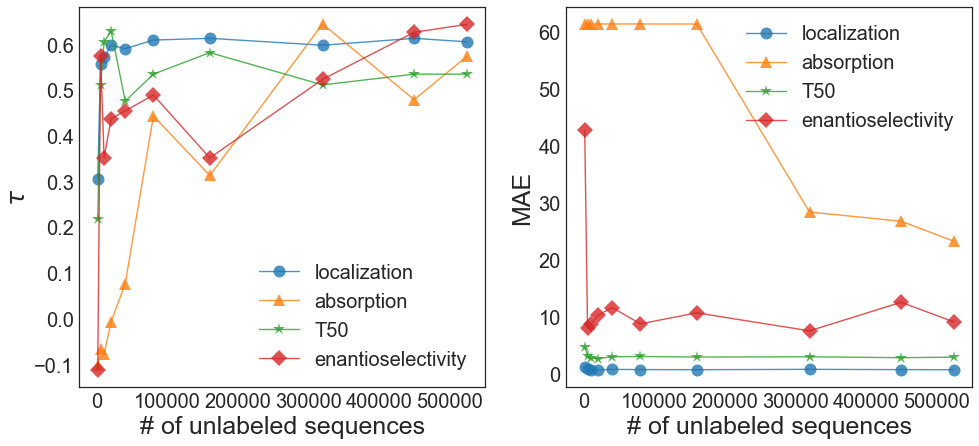

In [14]:
labels = ['localization', 'absorption', 'T50', 'enantioselectivity']
markers = ['-o', '-^', '-*', '-D']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for t, la, ma in zip(tasks, labels, markers):
    df_lim = res[res['task'] == t]
    df_lim = df_lim.sort_values('n')
    for i, metric in enumerate(['kendalltau', 'mae']):
        _ = axs[i].plot(df_lim['n'], df_lim[metric], ma, label=la, alpha=0.8, ms=12)
        _ = axs[i].legend()
        _ = axs[i].set_xlabel('# of unlabeled sequences')

_ = axs[0].set_ylabel(r'$\tau$')
_ = axs[1].set_ylabel('MAE')